In [362]:
import numpy as np
import skimage
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import filters
from skimage import segmentation
from skimage import data, exposure
from skimage.exposure import histogram
from skimage.feature import match_template
from skimage.transform import rescale
from skimage.util import random_noise
from scipy.signal import correlate2d
from skimage import io
from skimage.transform import resize

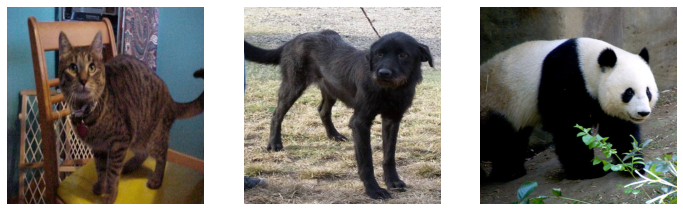

In [363]:
pixelsPerCells = (16,16)
size = 500

cats = [resize(io.imread(f"animals/cats/cats_" + f"{idx:05d}" + ".jpg"), (size, size)) for idx in range(1,20)]
dogs = [resize(io.imread(f"animals/dogs/dogs_"+ f"{idx:05d}" + ".jpg"), (size, size)) for idx in range(1,9)]
pandas = [resize(io.imread(f"animals/pandas/panda_" + f"{idx:05d}" + ".jpg"), (size, size)) for idx in range(1,9)]
images = cats + dogs + pandas

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
axes[0].imshow(cats[0]) and axes[0].axis('off')
axes[1].imshow(dogs[0]) and axes[1].axis('off')
axes[2].imshow(pandas[0]) and axes[2].axis('off')

plt.show()

In [364]:

cats_hog = [hog(img, orientations=8, pixels_per_cell=pixelsPerCells,
                    cells_per_block=(1, 1), channel_axis=2) for img in cats]
dogs_hog = [hog(img, orientations=8, pixels_per_cell=pixelsPerCells,
                    cells_per_block=(1, 1), channel_axis=2) for img in dogs]
pandas_hog = [hog(img, orientations=8, pixels_per_cell=pixelsPerCells,
                    cells_per_block=(1, 1), channel_axis=2) for img in pandas]

# étiquettes (1 pour les vélos, 2 pour les voitures)
cats_labels = 1 * np.ones((len(cats_hog), ))
dogs_labels = 2 * np.ones((len(dogs_hog), ))
pandas_labels = 3 * np.ones((len(pandas_hog), ))

dataset = np.concatenate((cats_hog, dogs_hog, pandas_hog))
labels = np.concatenate((cats_labels, dogs_labels, pandas_labels)).astype("int")
print(labels.shape)

(35,)


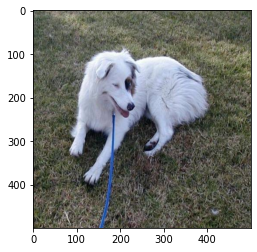

In [365]:
query = resize(io.imread("animals/dogs/dogs_" + f"{8:05d}" + ".jpg"), (size, size))
plt.imshow(query) and plt.show()

[26 19 33 24  4 23 31 21  1 34  3 29  7 32  0 13 25 11  9 30 27 28  8 22
 18 20 16 15 14 17 12  6  5 10  2]
Étiquettes des 17 images les plus proches : [2 2 3 2 1 2 3 2 1 3 1 3 1 3 1 1 2]
Étiquette majoritaire : 1


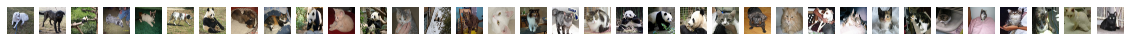

In [366]:
hog_query = hog(query, orientations=8, pixels_per_cell=pixelsPerCells,
                    cells_per_block=(1, 1), channel_axis=2)
scores = np.array([np.linalg.norm(hog_query - hog) for hog in dataset])

closest = np.argsort(scores)
print(closest)
fig, axes = plt.subplots(nrows=1, ncols=len(closest), figsize=(20, 8))
for idx, img_idx in enumerate(closest):
    axes[idx].imshow(images[img_idx]) and axes[idx].axis('off')

k = 17
closest_labels = labels[closest[:k]]
print(f"Étiquettes des {k} images les plus proches : {closest_labels}")
print(f"Étiquette majoritaire : {np.argmax(np.bincount(closest_labels))}")

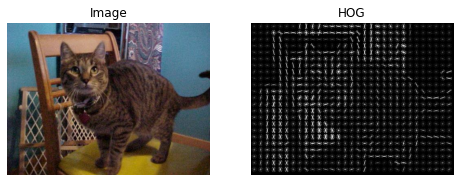

In [367]:
image = io.imread(f"animals/cats/cats_" + f"{1:05d}" + ".jpg")

descriptor, hog_image = hog(image, orientations=8, pixels_per_cell=pixelsPerCells,
                    cells_per_block=(1, 1), visualize=True, channel_axis=2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(image, cmap="gray") and ax1.set_title("Image")

# Amélioration du contraste
hog_image = exposure.rescale_intensity(hog_image, in_range=(0, 10))
ax2.axis('off')
ax2.imshow(hog_image, cmap="gray") and ax2.set_title("HOG")
plt.show()

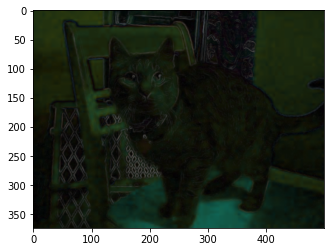

In [368]:
elevation_map = filters.sobel(image)
plt.imshow(elevation_map, cmap="gray") and plt.show()

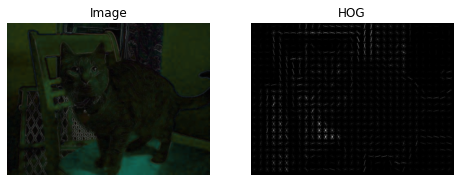

In [369]:
descriptor, hog_image = hog(elevation_map, orientations=8, pixels_per_cell=pixelsPerCells,
                    cells_per_block=(1, 1), visualize=True, channel_axis=2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(elevation_map, cmap="gray") and ax1.set_title("Image")

# Amélioration du contraste
hog_image = exposure.rescale_intensity(hog_image, in_range=(0, 10))
ax2.axis('off')
ax2.imshow(hog_image, cmap="gray") and ax2.set_title("HOG")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


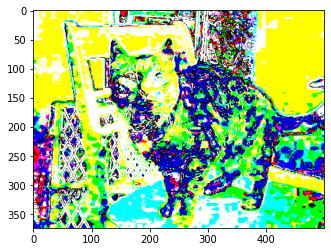

In [370]:
markers = np.zeros_like(elevation_map)
markers[elevation_map < np.percentile(elevation_map, 10)] = 1
markers[elevation_map > np.percentile(elevation_map, 50)] = 2
plt.imshow(markers) and plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


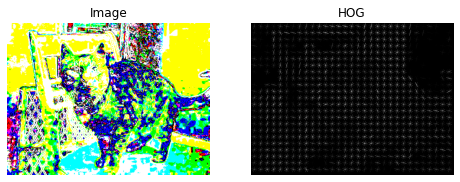

In [371]:
#image = io.imread(f"animals/cats/cats_00009.jpg")
image = markers

descriptor, hog_image = hog(image, orientations=8, pixels_per_cell=pixelsPerCells,
                    cells_per_block=(1, 1), visualize=True, channel_axis=2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(image, cmap="gray") and ax1.set_title("Image")

# Amélioration du contraste
hog_image = exposure.rescale_intensity(hog_image, in_range=(0, 10))
ax2.axis('off')
ax2.imshow(hog_image, cmap="gray") and ax2.set_title("HOG")
plt.show()

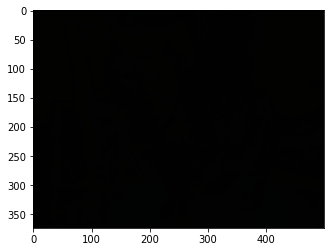

In [372]:
regions = segmentation.watershed(elevation_map, markers)
plt.imshow(regions) and plt.show()